# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

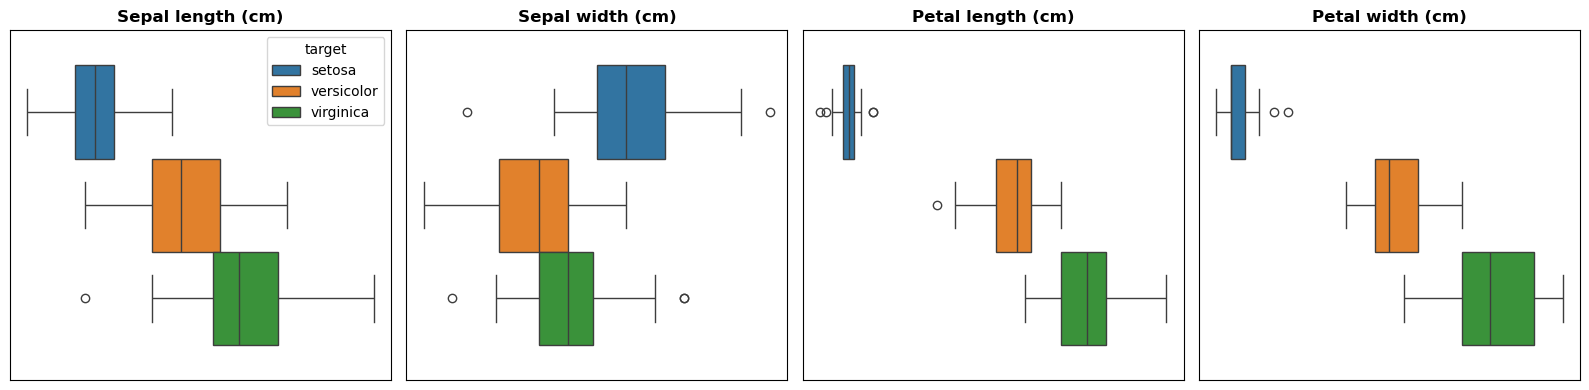

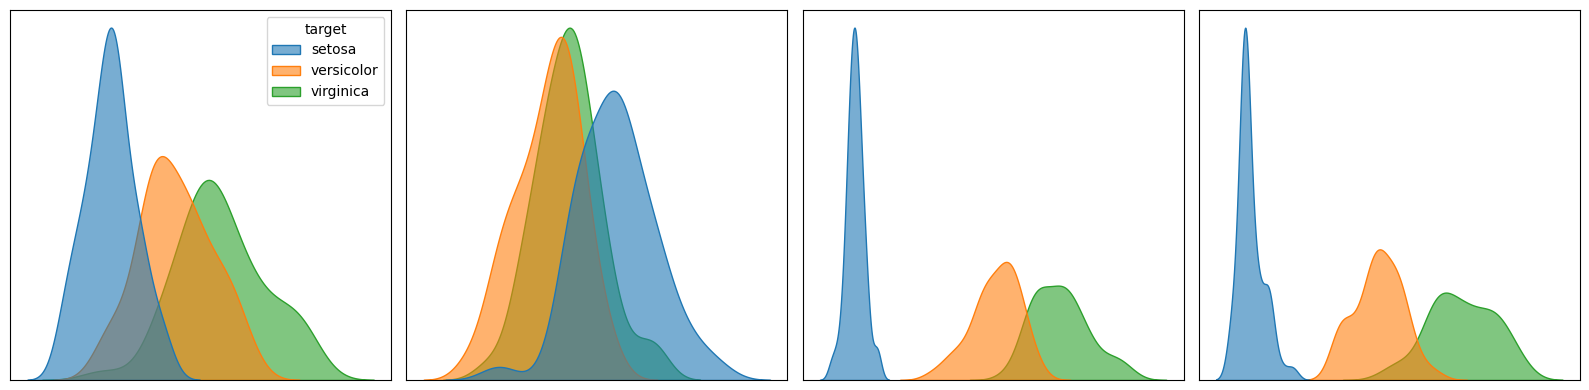

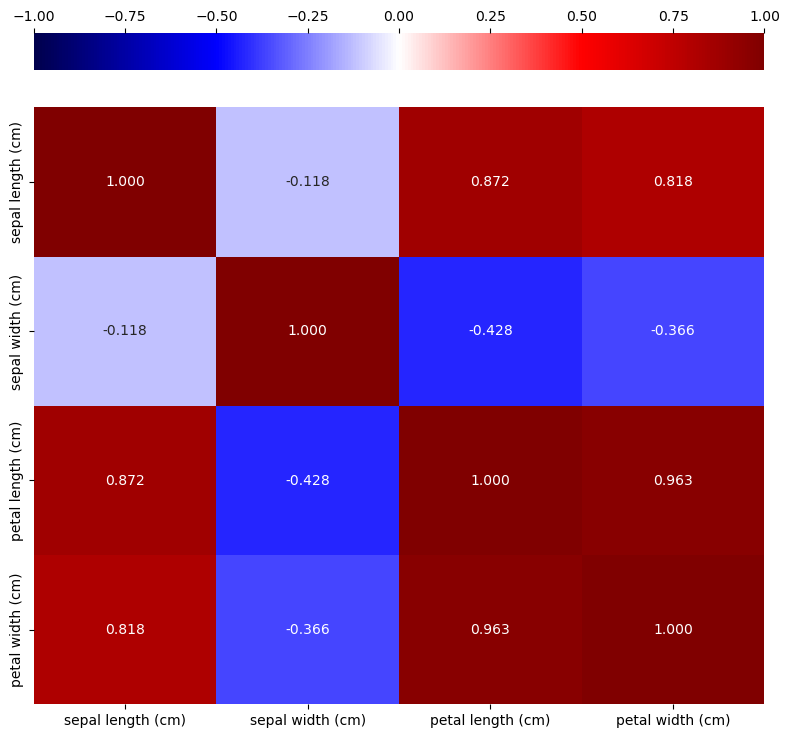

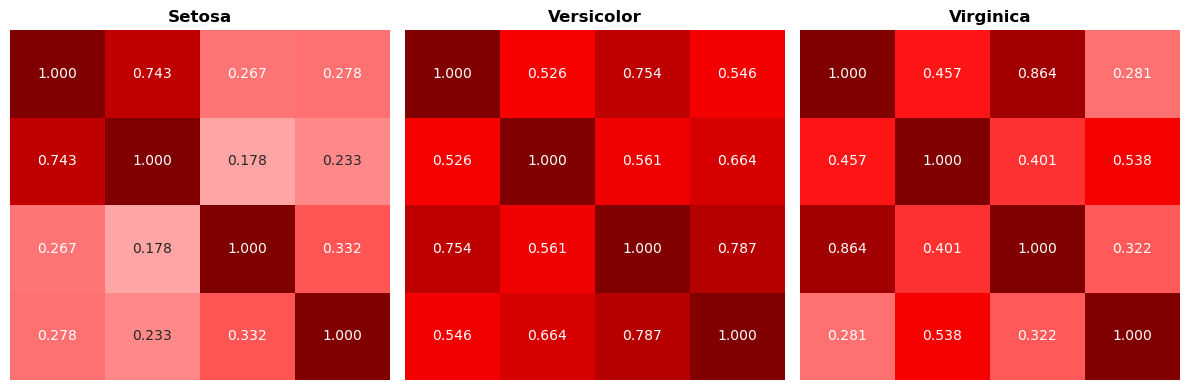

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.268777,2.841041,2.644441,0.894788,setosa
1,4.461760,2.216597,1.095574,-0.300169,setosa
2,5.133022,4.061320,1.748458,0.822170,setosa
3,4.790658,1.648080,1.253085,0.247968,setosa
4,2.613650,3.710214,2.524682,-0.664396,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.834      5.893   
     sepal width (cm)   3.428      2.770     2.974     3.393      2.582   
     petal length (cm)  1.462      4.260     5.552     1.798      3.903   
     petal width (cm)   0.246      1.326     2.026    -0.004      1.228   
STD  sepal length (cm)  0.352      0.516     0.636     1.032      1.079   
     sepal width (cm)   0.379      0.314     0.322     1.350      1.109   
     petal length (cm)  0.174      0.470     0.552     1.003      0.992   
     petal width (cm)   0.105      0.198     0.275     1.009      1.163   
MIN  sepal length (cm)  4.300      4.900     4.900     2.614      3.501   
     sepal width (cm)   2.300      2.000     2.200     0.203      0.238   
     petal length (cm)  1.000      3.000     4.500    -1.236      1.521   
     petal width (cm)   0.100      1.000     1.400    -2.307     -1.002   
MAX  sepal length (cm)  5.800      7.000     7.900     7.343      8.134   
     sepal width (cm)   4.400      3.400     3.800     5.714      5.092   
     petal length (cm)  1.900      5.100     6.900     3.696      6.020   
     petal width (cm)   0.600      1.800     2.500     2.930      3.932   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.180     -0.006   
     sepal width (cm)   0.040     -0.352     0.355    -0.445     -0.275   
     petal length (cm)  0.103     -0.588     0.533    -0.461     -0.206   
     petal width (cm)   1.216     -0.030    -0.126     0.350      0.401   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.141     -0.455   
     sepal width (cm)   0.744     -0.448     0.520    -0.431     -0.078   
     petal length (cm)  0.805     -0.074    -0.256     0.501     -0.078   
     petal width (cm)   1.434     -0.488    -0.661     0.310     -0.419   
IQR  sepal length (cm)  0.400      0.700     0.675     0.995      1.310   
     sepal width (cm)   0.475      0.475     0.375     1.923      1.138   
     petal length (cm)  0.175      0.600     0.775     1.373      1.158   
     petal width (cm)   0.100      0.300     0.500     1.379      1.365   

                                  
                       virginica  
MEAN sepal length (cm)     6.606  
     sepal width (cm)      2.826  
     petal length (cm)     5.529  
     petal width (cm)      2.209  
STD  sepal length (cm)     1.168  
     sepal width (cm)      1.135  
     petal length (cm)     1.071  
     petal width (cm)      1.056  
MIN  sepal length (cm)     4.443  
     sepal width (cm)      0.120  
     petal length (cm)     2.521  
     petal width (cm)      0.334  
MAX  sepal length (cm)     9.376  
     sepal width (cm)      5.286  
     petal length (cm)     7.674  
     petal width (cm)      4.307  
SKEW sepal length (cm)     0.231  
     sepal width (cm)      0.477  
     petal length (cm)    -0.380  
     petal width (cm)     -0.012  
KURT sepal length (cm)    -0.258  
     sepal width (cm)     -0.094  
     petal length (cm)     0.523  
     petal width (cm)     -1.141  
IQR  sepal length (cm)     1.171  
     sepal width (cm)      1.121  
     petal length (cm)     1.004  
     petal width (cm)      1.869

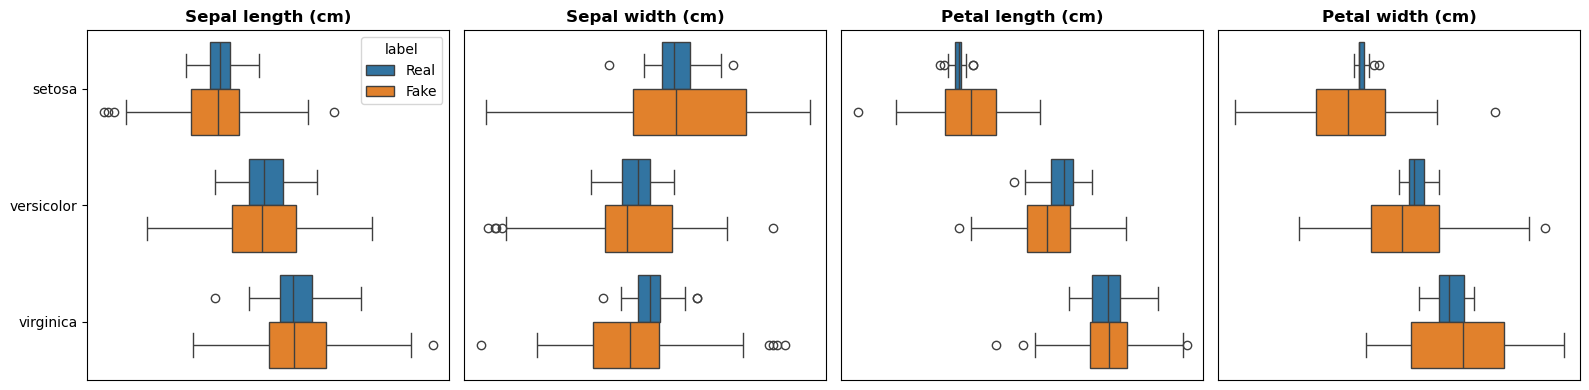

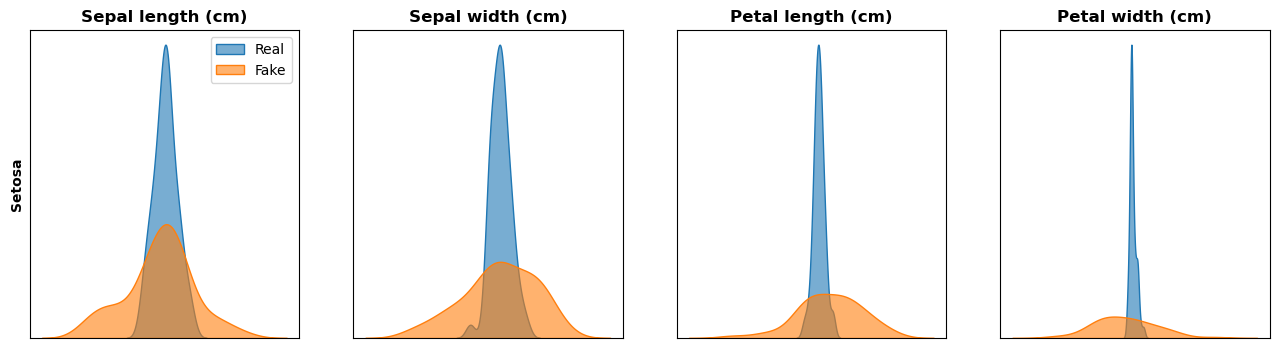

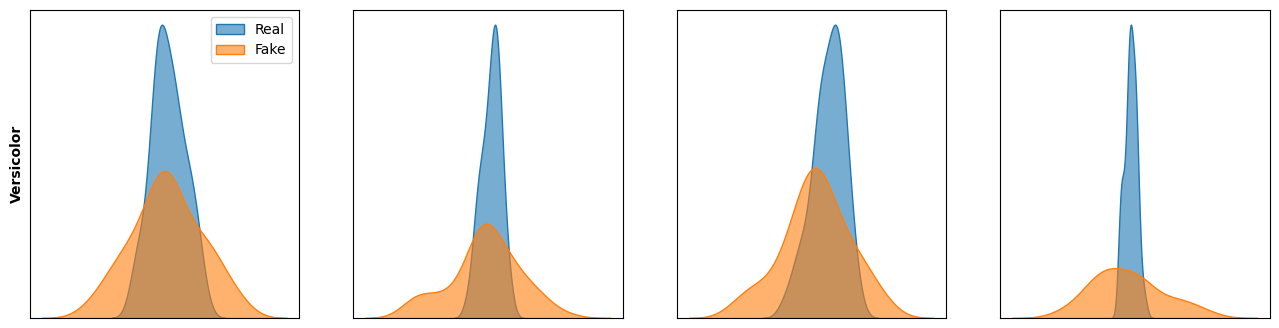

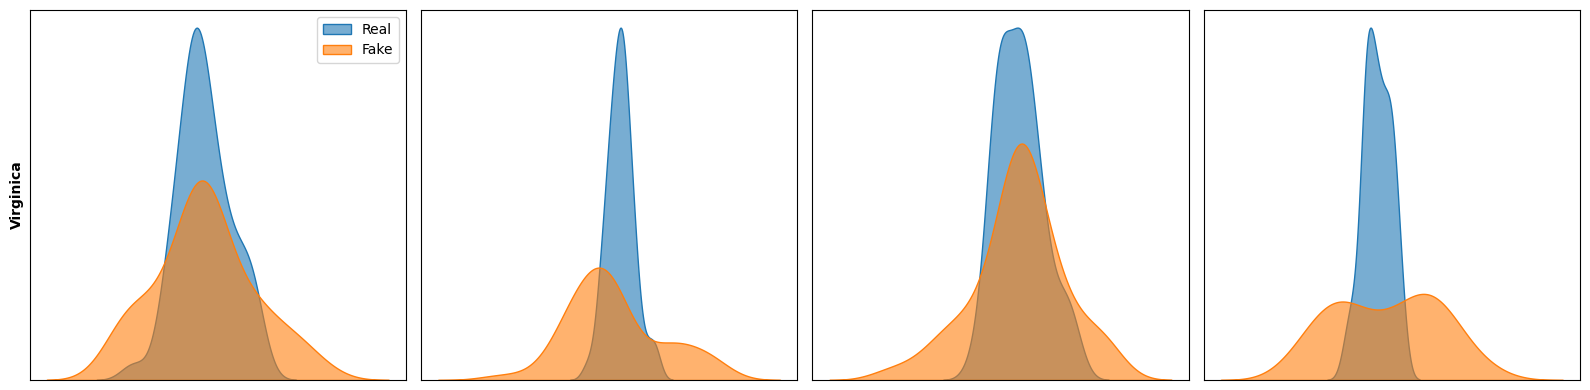

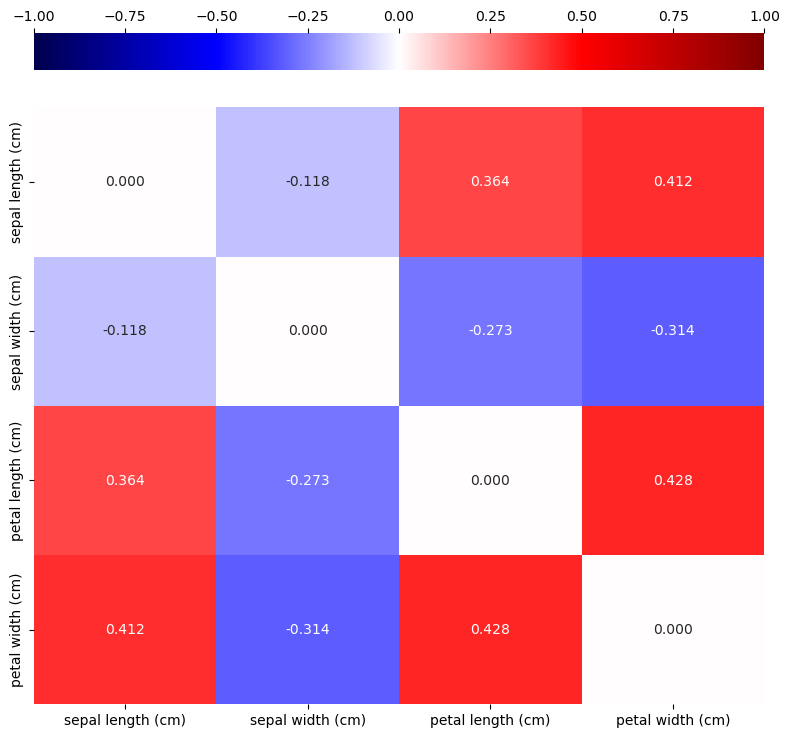

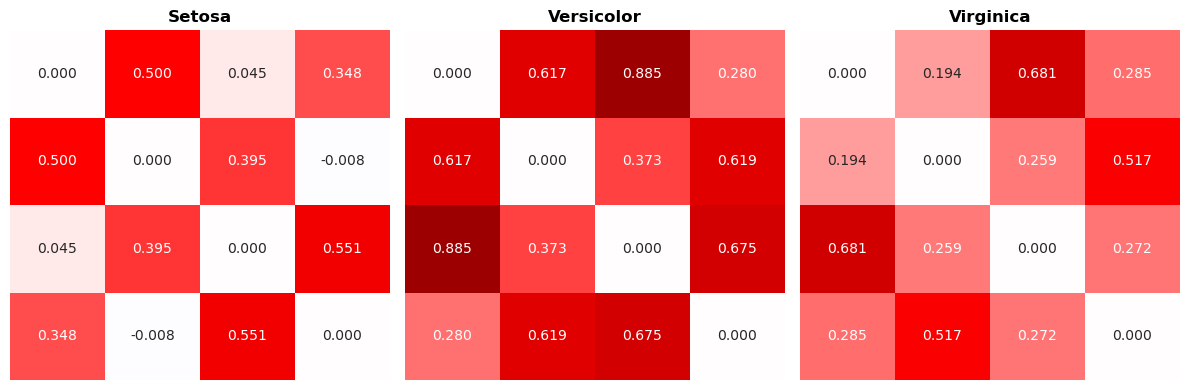

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [74]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()  # Output compreso tra 0 e 1
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
    
vae = ConditionalVAE(input_dim = 4, latent_dim = 2, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 2])
Shape: torch.Size([32, 2])


Now let's build the GANs net.

In [75]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 4)
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
    
gen = Generator(input_dim = 2, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 2), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [76]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')

VAE has 1624 parameters
Gen has 797 parameters


In [77]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    # Loss totale
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)

In [78]:
for epoch in tqdm(range(1, 21), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for batch, (data, label) in enumerate(real_vae_dataloader):
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 5 == 0 or epoch == 20:
        
        print(f'\nEpoch {epoch}/20 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 5/20 | Loss: 0.9462
MEAN: [-0.002 -0.047  0.008 -0.202]
STD:  [0.966 0.936 0.927 0.939]
MIN:  [-1.802 -2.3   -1.395 -1.514]
MAX:  [2.425 2.867 1.578 1.366]
SKEW: [ 0.079  0.372 -0.33  -0.012]
KURT: [ 0.653  0.251 -0.698 -0.808]

Epoch 10/20 | Loss: 0.8760
MEAN: [-0.058  0.001 -0.051 -0.203]
STD:  [0.912 0.909 0.878 0.879]
MIN:  [-1.788 -2.222 -1.392 -1.435]
MAX:  [2.259 2.89  1.432 1.228]
SKEW: [ 0.072  0.279 -0.183 -0.338]
KURT: [ 0.762  0.754 -0.386 -0.351]

Epoch 15/20 | Loss: 0.7552
MEAN: [-0.102  0.06  -0.094 -0.219]
STD:  [0.815 0.859 0.784 0.781]
MIN:  [-1.595 -2.121 -1.239 -1.169]
MAX:  [2.021 2.804 1.062 0.996]
SKEW: [ 0.218 -0.168 -0.174 -0.124]
KURT: [ 0.637  1.133 -0.594 -0.303]

Epoch 20/20 | Loss: 0.5986
MEAN: [-0.102  0.078 -0.114 -0.212]
STD:  [0.651 0.773 0.621 0.627]
MIN:  [-1.341 -2.117 -1.004 -0.937]
MAX:  [1.868 2.667 1.068 0.933]
SKEW: [ 0.384 -0.426  0.088  0.067]
KURT: [ 0.778  1.271 -0.04  -0.044]


In [79]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [80]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.575      5.934   
     sepal width (cm)   3.428      2.770     2.974     3.159      2.955   
     petal length (cm)  1.462      4.260     5.552     3.077      4.147   
     petal width (cm)   0.246      1.326     2.026     1.006      1.383   
STD  sepal length (cm)  0.352      0.516     0.636     0.067      0.038   
     sepal width (cm)   0.379      0.314     0.322     0.036      0.018   
     petal length (cm)  0.174      0.470     0.552     0.128      0.128   
     petal width (cm)   0.105      0.198     0.275     0.074      0.037   
MIN  sepal length (cm)  4.300      4.900     4.900     5.407      5.830   
     sepal width (cm)   2.300      2.000     2.200     3.117      2.922   
     petal length (cm)  1.000      3.000     4.500     2.766      3.881   
     petal width (cm)   0.100      1.000     1.400     0.812      1.293   
MAX  sepal length (cm)  5.800      7.000     7.900     5.685      6.001   
     sepal width (cm)   4.400      3.400     3.800     3.241      2.999   
     petal length (cm)  1.900      5.100     6.900     3.328      4.416   
     petal width (cm)   0.600      1.800     2.500     1.109      1.457   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.913     -0.588   
     sepal width (cm)   0.040     -0.352     0.355     0.831      0.317   
     petal length (cm)  0.103     -0.588     0.533    -0.734      0.152   
     petal width (cm)   1.216     -0.030    -0.126    -0.950     -0.308   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.196      0.041   
     sepal width (cm)   0.744     -0.448     0.520    -0.564     -0.301   
     petal length (cm)  0.805     -0.074    -0.256    -0.261     -0.415   
     petal width (cm)   1.434     -0.488    -0.661    -0.083     -0.497   
IQR  sepal length (cm)  0.400      0.700     0.675     0.092      0.047   
     sepal width (cm)   0.475      0.475     0.375     0.056      0.025   
     petal length (cm)  0.175      0.600     0.775     0.188      0.172   
     petal width (cm)   0.100      0.300     0.500     0.104      0.050   

                                  
                       virginica  
MEAN sepal length (cm)     6.274  
     sepal width (cm)      2.957  
     petal length (cm)     4.652  
     petal width (cm)      1.690  
STD  sepal length (cm)     0.043  
     sepal width (cm)      0.028  
     petal length (cm)     0.158  
     petal width (cm)      0.050  
MIN  sepal length (cm)     6.179  
     sepal width (cm)      2.920  
     petal length (cm)     4.429  
     petal width (cm)      1.588  
MAX  sepal length (cm)     6.359  
     sepal width (cm)      3.016  
     petal length (cm)     5.020  
     petal width (cm)      1.791  
SKEW sepal length (cm)     0.063  
     sepal width (cm)      0.744  
     petal length (cm)     0.522  
     petal width (cm)      0.185  
KURT sepal length (cm)    -0.529  
     sepal width (cm)     -0.579  
     petal length (cm)    -0.888  
     petal width (cm)     -0.791  
IQR  sepal length (cm)     0.056  
     sepal width (cm)      0.041  
     petal length (cm)     0.256  
     petal width (cm)      0.074

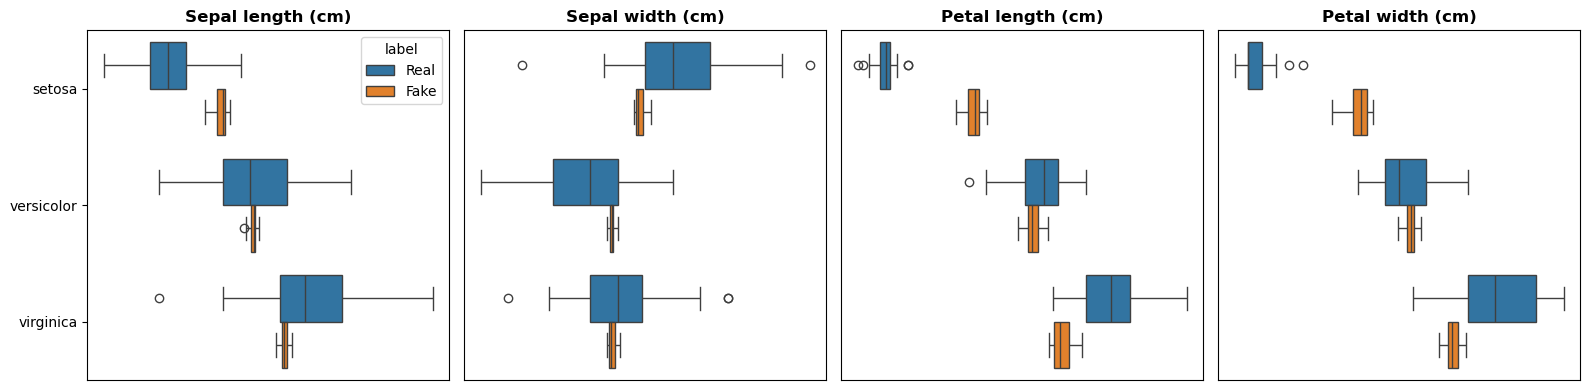

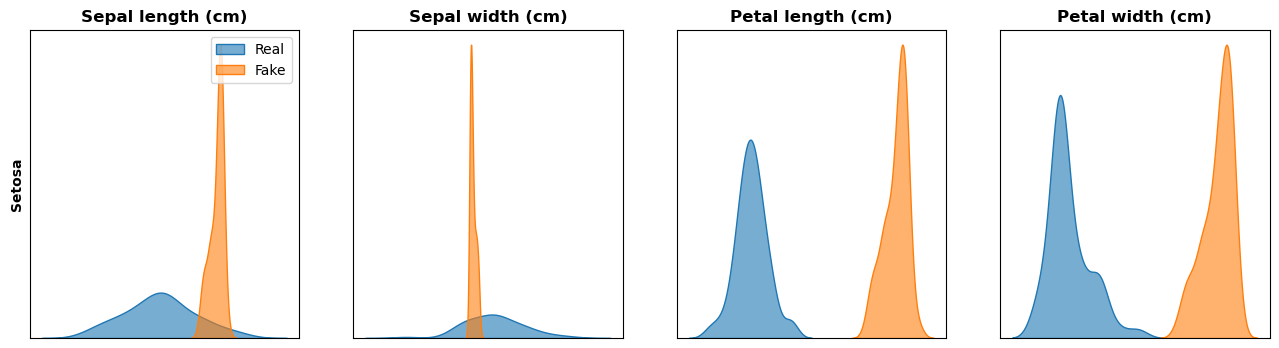

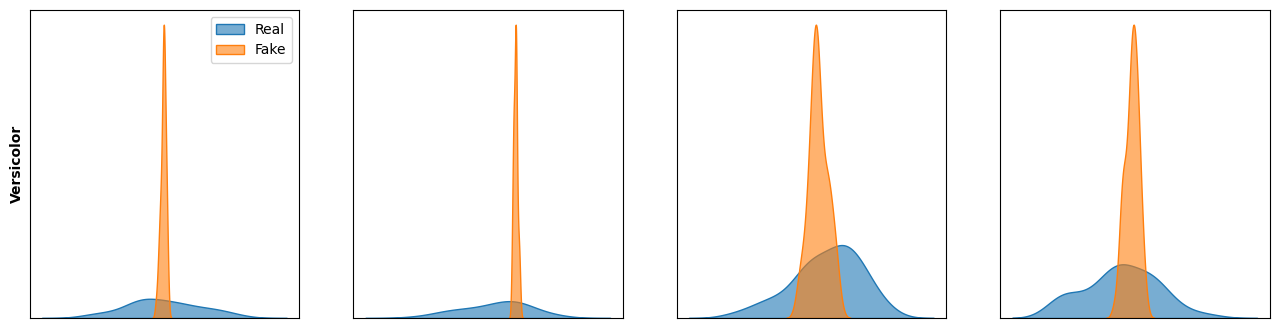

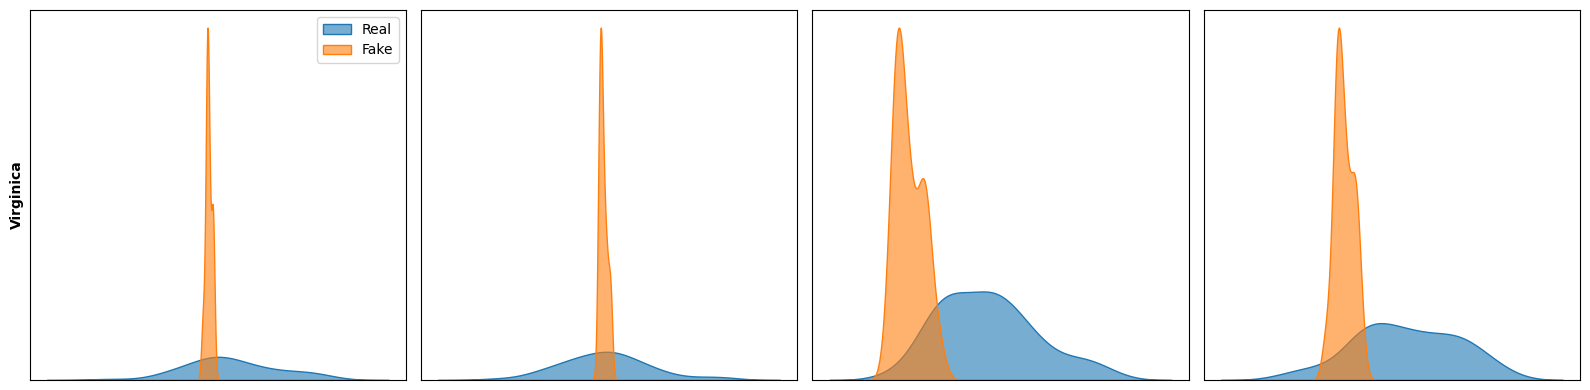

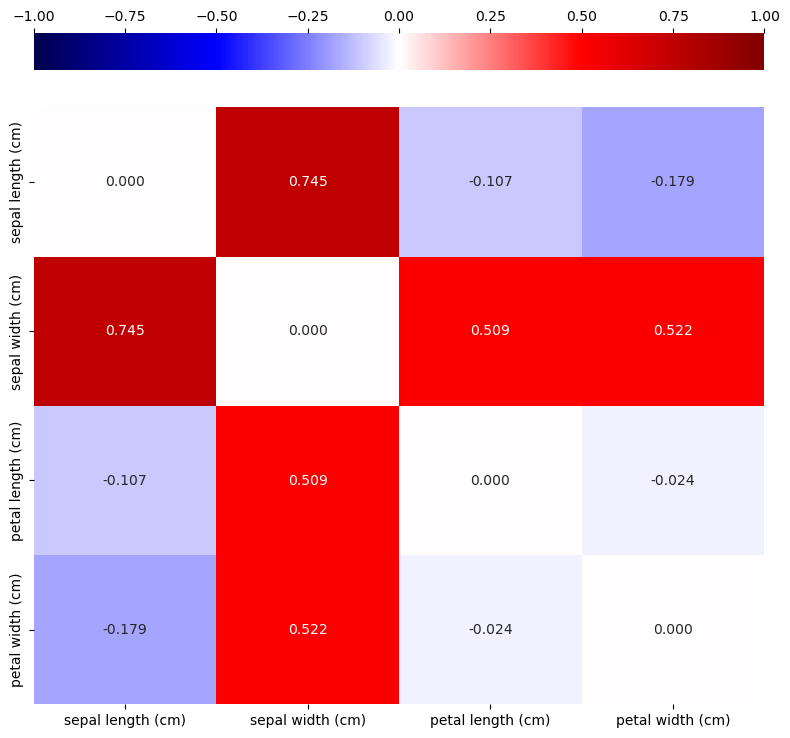

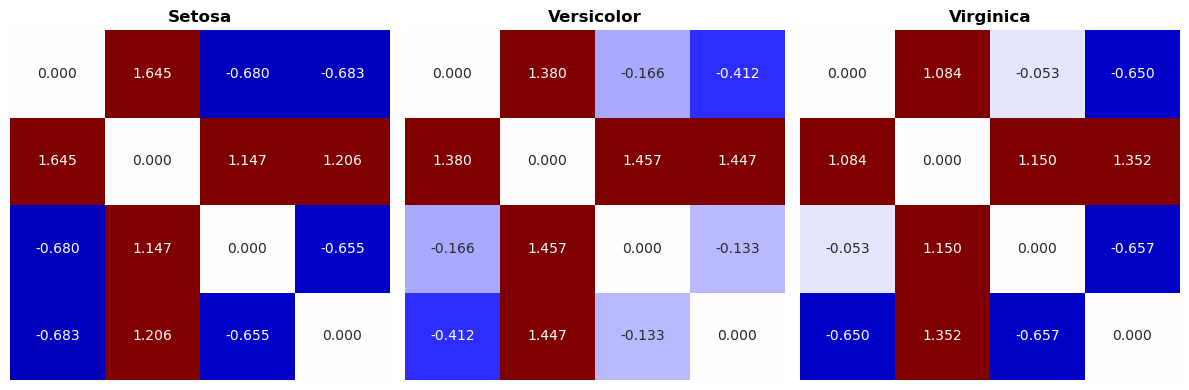

In [81]:
utils.plot_data(real_iris, 'target', vae_df)